# Vendr Customer Savings & NRR Analysis

## Completed Analysis
- [x] Average savings per customer by company size tier
- [x] Net Revenue Retention (NRR) analysis with expansion/churn breakdown
- [x] NRR by company size visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'green': '#4ca86f', 'yellow': '#fec163'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Vendr database
engine = create_engine(os.environ['VENDR_CONNECTION_URL'])

# Query: Calculate savings per customer with company size
query = """
SELECT 
    c.id AS customer_id,
    c.company_name,
    c.employee_count,
    c.industry,
    c.plan_tier,
    COUNT(d.id) AS total_deals,
    SUM(d.original_price_usd - d.negotiated_price_usd) AS total_savings,
    AVG(d.original_price_usd - d.negotiated_price_usd) AS avg_savings_per_deal
FROM public.customers c
JOIN public.deals d ON c.id = d.customer_id
WHERE d.status = 'closed_won'
GROUP BY c.id, c.company_name, c.employee_count, c.industry, c.plan_tier
"""

df = pd.read_sql(query, engine)
engine.dispose()

# Create company size tiers
def size_tier(emp):
    if emp < 100: return 'Small (<100)'
    elif emp < 500: return 'Mid-Market (100-500)'
    elif emp < 2000: return 'Enterprise (500-2K)'
    else: return 'Large Enterprise (2K+)'

df['size_tier'] = df['employee_count'].apply(size_tier)
df['size_tier'] = pd.Categorical(df['size_tier'], 
    categories=['Small (<100)', 'Mid-Market (100-500)', 'Enterprise (500-2K)', 'Large Enterprise (2K+)'],
    ordered=True)

print(f"Customers with closed deals: {len(df):,}")
print(f"Total savings delivered: ${df['total_savings'].sum():,.0f}")
df.head()

Customers with closed deals: 350
Total savings delivered: $34,094,799


,customer_id,company_name,employee_count,industry,plan_tier,total_deals,total_savings,avg_savings_per_deal,size_tier
0,11,Company_10010,160,technology,starter,5,22949.43,5737.357500,Mid-Market (100-500)
1,267,Company_10266,824,technology,professional,8,71271.79,11878.631667,Enterprise (500-2K)
2,148,Company_10147,290,technology,professional,8,81224.08,10153.010000,Mid-Market (100-500)
3,7,Company_10006,1907,retail,enterprise,10,152818.84,19102.355000,Enterprise (500-2K)
4,336,Company_10335,125,retail,starter,5,22814.35,7604.783333,Mid-Market (100-500)


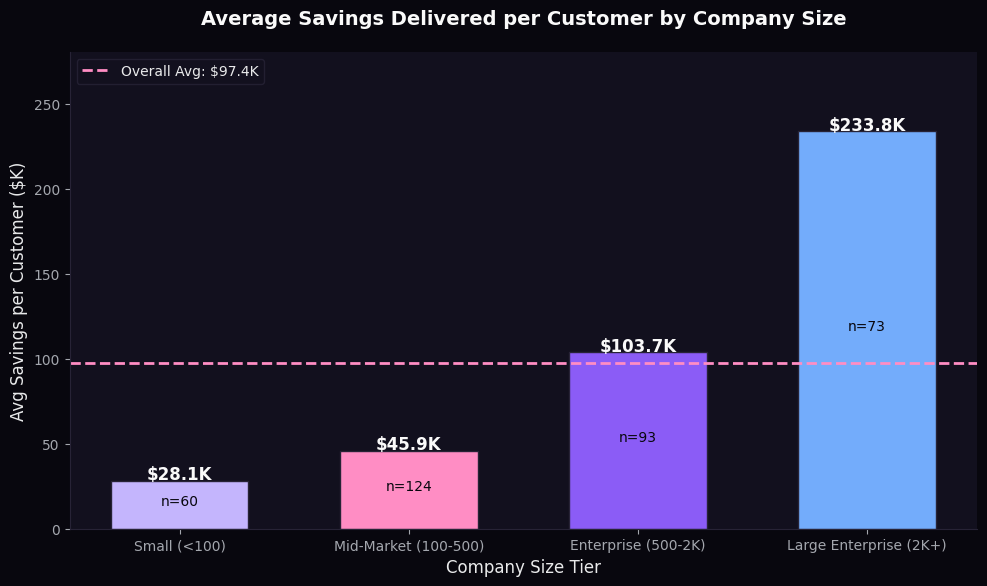

,size_tier,customers,avg_savings_per_customer,median_savings,total_savings
0,Small (<100),60,"$28,064","$28,578","$1,683,826"
1,Mid-Market (100-500),124,"$45,925","$31,735","$5,694,718"
2,Enterprise (500-2K),93,"$103,744","$77,221","$9,648,215"
3,Large Enterprise (2K+),73,"$233,809","$245,225","$17,068,040"


In [2]:
# Calculate average savings per customer by company size tier
tier_stats = df.groupby('size_tier', observed=True).agg(
    customers=('customer_id', 'count'),
    avg_savings_per_customer=('total_savings', 'mean'),
    median_savings=('total_savings', 'median'),
    total_savings=('total_savings', 'sum')
).reset_index()

# Overall average
overall_avg = df['total_savings'].mean()

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(tier_stats['size_tier'].astype(str), tier_stats['avg_savings_per_customer'] / 1000, 
              color=CATEGORICAL_PALETTE[:4], width=0.6, edgecolor='#272336')

# Add value labels
for bar, val, n in zip(bars, tier_stats['avg_savings_per_customer'], tier_stats['customers']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
           f'${val/1000:.1f}K', ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
           f'n={n}', ha='center', fontsize=10, color='#08070e')

# Add overall average line
ax.axhline(y=overall_avg/1000, color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Overall Avg: ${overall_avg/1000:.1f}K')

ax.set_xlabel('Company Size Tier')
ax.set_ylabel('Avg Savings per Customer ($K)')
ax.set_title('Average Savings Delivered per Customer by Company Size', fontweight='bold', pad=20)
ax.legend(loc='upper left')
ax.set_ylim(0, tier_stats['avg_savings_per_customer'].max()/1000 * 1.2)

plt.tight_layout()
plt.show()

# Summary table
tier_stats['avg_savings_per_customer'] = tier_stats['avg_savings_per_customer'].apply(lambda x: f'${x:,.0f}')
tier_stats['total_savings'] = tier_stats['total_savings'].apply(lambda x: f'${x:,.0f}')
tier_stats['median_savings'] = tier_stats['median_savings'].apply(lambda x: f'${x:,.0f}')
tier_stats

In [3]:
# NRR Analysis: Are customers renewing and expanding?
query_nrr = """
SELECT 
    r.id,
    r.customer_id,
    r.renewal_date,
    r.prior_acv_usd,
    r.new_acv_usd,
    r.status,
    r.churn_reason,
    c.employee_count,
    c.industry,
    c.plan_tier
FROM public.renewals r
JOIN public.customers c ON r.customer_id = c.id
"""

df_renewals = pd.read_sql(query_nrr, create_engine(os.environ['VENDR_CONNECTION_URL']))
df_renewals['renewal_date'] = pd.to_datetime(df_renewals['renewal_date'])

# Calculate individual renewal metrics
df_renewals['expansion'] = df_renewals['new_acv_usd'] - df_renewals['prior_acv_usd']
df_renewals['growth_rate'] = (df_renewals['new_acv_usd'] / df_renewals['prior_acv_usd'] - 1) * 100

# Classify renewal outcomes
def classify_renewal(row):
    if row['status'] == 'churned': return 'Churned'
    elif row['new_acv_usd'] > row['prior_acv_usd'] * 1.05: return 'Expanded'
    elif row['new_acv_usd'] < row['prior_acv_usd'] * 0.95: return 'Contracted'
    else: return 'Flat'

df_renewals['outcome'] = df_renewals.apply(classify_renewal, axis=1)

# Add company size tier
df_renewals['size_tier'] = df_renewals['employee_count'].apply(size_tier)
df_renewals['size_tier'] = pd.Categorical(df_renewals['size_tier'], 
    categories=['Small (<100)', 'Mid-Market (100-500)', 'Enterprise (500-2K)', 'Large Enterprise (2K+)'],
    ordered=True)

print(f"Total renewals analyzed: {len(df_renewals):,}")
print(f"\nRenewal Outcomes:")
print(df_renewals['outcome'].value_counts())

Total renewals analyzed: 280

Renewal Outcomes:
outcome
Expanded    218
Churned      57
Flat          5
Name: count, dtype: int64


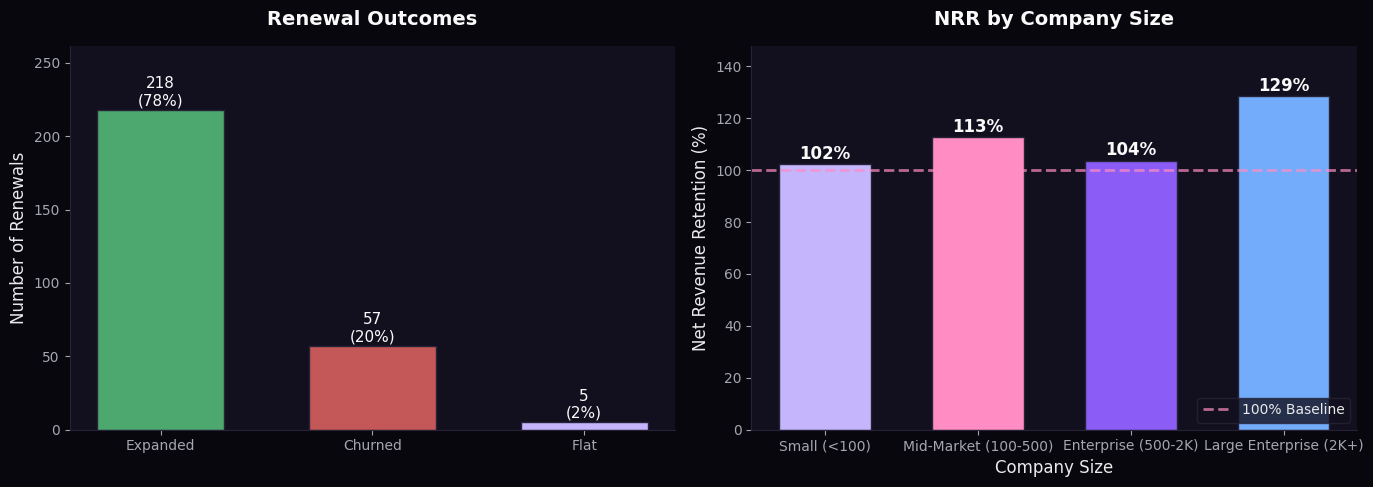

In [6]:
# Calculate NRR metrics
renewed = df_renewals[df_renewals['status'] != 'churned']
churned = df_renewals[df_renewals['status'] == 'churned']

total_prior_acv = df_renewals['prior_acv_usd'].sum()
total_new_acv = renewed['new_acv_usd'].sum()  # Churned = 0 revenue retained
nrr = (total_new_acv / total_prior_acv) * 100

# Gross Revenue Retention (ignoring expansion)
grr = (renewed['prior_acv_usd'].sum() / total_prior_acv) * 100

# Expansion rate among renewals
expansion_revenue = renewed[renewed['new_acv_usd'] > renewed['prior_acv_usd']]
expansion_rate = (expansion_revenue['expansion'].sum() / renewed['prior_acv_usd'].sum()) * 100

# Create visualization - 2 panels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Renewal Outcome Distribution
outcome_counts = df_renewals['outcome'].value_counts()
outcome_colors = {'Expanded': '#4ca86f', 'Flat': '#c4b5fd', 
                  'Contracted': '#fec163', 'Churned': '#c45757'}
colors = [outcome_colors[x] for x in outcome_counts.index]

bars = axes[0].bar(outcome_counts.index, outcome_counts.values, color=colors, width=0.6, edgecolor='#272336')
for bar, val in zip(bars, outcome_counts.values):
    pct = val / len(df_renewals) * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
                f'{val}\n({pct:.0f}%)', ha='center', fontsize=11, color='#FAFAFA')
axes[0].set_ylabel('Number of Renewals')
axes[0].set_title('Renewal Outcomes', fontweight='bold', pad=15)
axes[0].set_ylim(0, outcome_counts.max() * 1.2)

# Panel 2: NRR by Company Size
nrr_by_size = df_renewals.groupby('size_tier', observed=True)[['prior_acv_usd', 'new_acv_usd', 'status']].apply(
    lambda x: x[x['status'] != 'churned']['new_acv_usd'].sum() / x['prior_acv_usd'].sum() * 100,
    include_groups=False
).reset_index(name='nrr')

bars2 = axes[1].bar(nrr_by_size['size_tier'].astype(str), nrr_by_size['nrr'], 
                    color=CATEGORICAL_PALETTE[:4], width=0.6, edgecolor='#272336')
axes[1].axhline(y=100, color='#ff8dc4', linestyle='--', linewidth=2, alpha=0.7, label='100% Baseline')
for bar, val in zip(bars2, nrr_by_size['nrr']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:.0f}%', ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')
axes[1].set_ylabel('Net Revenue Retention (%)')
axes[1].set_xlabel('Company Size')
axes[1].set_title('NRR by Company Size', fontweight='bold', pad=15)
axes[1].set_ylim(0, nrr_by_size['nrr'].max() * 1.15)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [7]:
# Query deals with benchmark comparison
query_benchmark = """
SELECT 
    d.id AS deal_id,
    d.vendor_name,
    d.software_category,
    d.original_price_usd,
    d.negotiated_price_usd,
    d.status,
    c.employee_count,
    pb.benchmark_price_usd,
    pb.confidence_score,
    CASE 
        WHEN c.employee_count < 100 THEN 'small'
        WHEN c.employee_count < 500 THEN 'mid'
        ELSE 'large'
    END AS size_tier_key
FROM public.deals d
JOIN public.customers c ON d.customer_id = c.id
LEFT JOIN public.price_benchmarks pb 
    ON d.vendor_name = pb.vendor_name 
    AND pb.company_size_tier = CASE 
        WHEN c.employee_count < 100 THEN 'small'
        WHEN c.employee_count < 500 THEN 'mid'
        ELSE 'large'
    END
WHERE d.status = 'closed_won'
"""

df_bench = pd.read_sql(query_benchmark, create_engine(os.environ['VENDR_CONNECTION_URL']))

# Calculate benchmark comparison metrics
df_bench['vs_benchmark'] = (df_bench['negotiated_price_usd'] / df_bench['benchmark_price_usd'] - 1) * 100
df_bench['beat_benchmark'] = df_bench['negotiated_price_usd'] <= df_bench['benchmark_price_usd']
df_bench['savings_vs_benchmark'] = df_bench['benchmark_price_usd'] - df_bench['negotiated_price_usd']

# Filter to deals with valid benchmarks
df_matched = df_bench[df_bench['benchmark_price_usd'].notna()].copy()

print(f"Closed deals: {len(df_bench):,}")
print(f"Deals with benchmark match: {len(df_matched):,} ({len(df_matched)/len(df_bench)*100:.0f}%)")
print(f"\n📊 Benchmark Comparison Summary")
print(f"{'='*45}")
print(f"Deals beating benchmark:      {df_matched['beat_benchmark'].sum():,} ({df_matched['beat_benchmark'].mean()*100:.1f}%)")
print(f"Avg negotiated vs benchmark:  {df_matched['vs_benchmark'].mean():+.1f}%")
print(f"Median negotiated vs benchmark: {df_matched['vs_benchmark'].median():+.1f}%")

Closed deals: 7,083
Deals with benchmark match: 7,083 (100%)

📊 Benchmark Comparison Summary
Deals beating benchmark:      4,777 (67.4%)
Avg negotiated vs benchmark:  -15.5%
Median negotiated vs benchmark: -26.2%


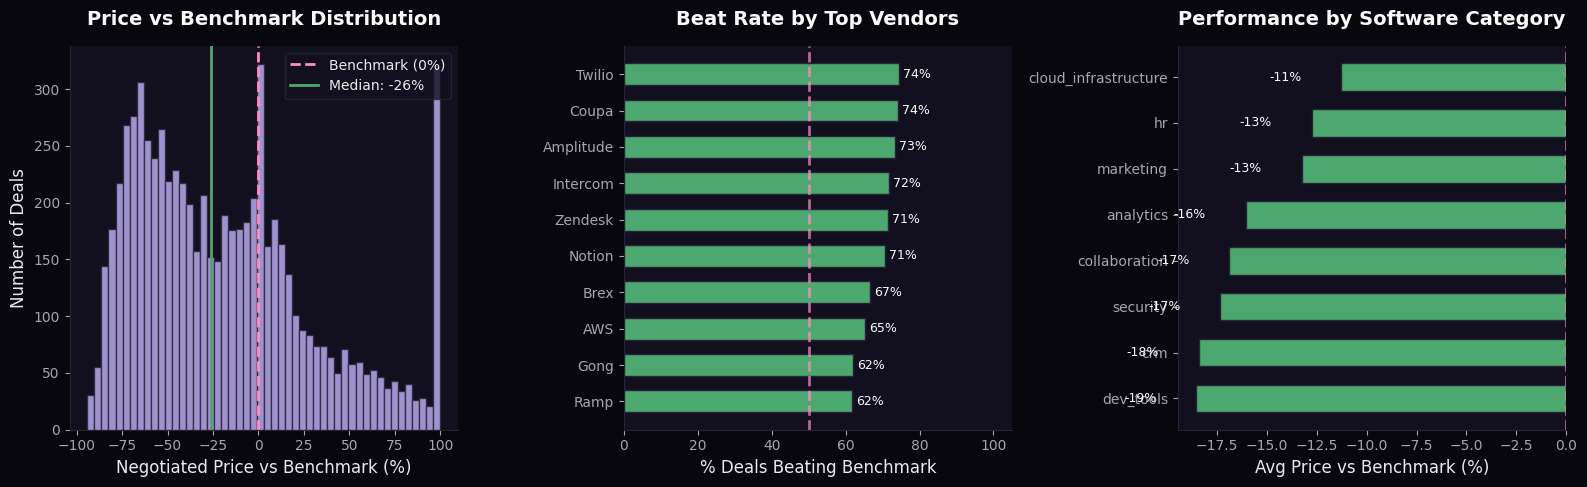

In [8]:
# Visualization: Benchmark comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Distribution of negotiated vs benchmark
axes[0].hist(df_matched['vs_benchmark'].clip(-100, 100), bins=50, color=COLORS['primary'], 
             edgecolor='#272336', alpha=0.8)
axes[0].axvline(x=0, color='#ff8dc4', linestyle='--', linewidth=2, label='Benchmark (0%)')
axes[0].axvline(x=df_matched['vs_benchmark'].median(), color='#4ca86f', linestyle='-', linewidth=2, 
                label=f'Median: {df_matched["vs_benchmark"].median():.0f}%')
axes[0].set_xlabel('Negotiated Price vs Benchmark (%)')
axes[0].set_ylabel('Number of Deals')
axes[0].set_title('Price vs Benchmark Distribution', fontweight='bold', pad=15)
axes[0].legend(loc='upper right')

# Panel 2: Beat rate by vendor (top 10 vendors by deal count)
top_vendors = df_matched['vendor_name'].value_counts().head(10).index
vendor_stats = df_matched[df_matched['vendor_name'].isin(top_vendors)].groupby('vendor_name').agg(
    beat_rate=('beat_benchmark', 'mean'),
    avg_vs_bench=('vs_benchmark', 'mean'),
    deals=('deal_id', 'count')
).sort_values('beat_rate', ascending=True)

colors_beat = ['#4ca86f' if x >= 0.5 else '#c45757' for x in vendor_stats['beat_rate']]
bars = axes[1].barh(vendor_stats.index, vendor_stats['beat_rate'] * 100, color=colors_beat, height=0.6, edgecolor='#272336')
axes[1].axvline(x=50, color='#ff8dc4', linestyle='--', linewidth=2, alpha=0.7)
for bar, rate in zip(bars, vendor_stats['beat_rate']):
    axes[1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{rate*100:.0f}%', va='center', fontsize=9, color='#FAFAFA')
axes[1].set_xlabel('% Deals Beating Benchmark')
axes[1].set_title('Beat Rate by Top Vendors', fontweight='bold', pad=15)
axes[1].set_xlim(0, 105)

# Panel 3: Avg discount vs benchmark by software category
cat_stats = df_matched.groupby('software_category').agg(
    avg_vs_bench=('vs_benchmark', 'mean'),
    deals=('deal_id', 'count')
).sort_values('avg_vs_bench')

colors_cat = ['#4ca86f' if x < 0 else '#c45757' for x in cat_stats['avg_vs_bench']]
bars = axes[2].barh(cat_stats.index, cat_stats['avg_vs_bench'], color=colors_cat, height=0.6, edgecolor='#272336')
axes[2].axvline(x=0, color='#ff8dc4', linestyle='--', linewidth=2, alpha=0.7, label='Benchmark')
for bar, val in zip(bars, cat_stats['avg_vs_bench']):
    axes[2].text(val - 2 if val < 0 else val + 1, bar.get_y() + bar.get_height()/2,
                f'{val:+.0f}%', va='center', ha='right' if val < 0 else 'left', fontsize=9, color='#FAFAFA')
axes[2].set_xlabel('Avg Price vs Benchmark (%)')
axes[2].set_title('Performance by Software Category', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

In [9]:
# Time-to-close analysis by deal type
query_ttc = """
SELECT 
    d.id AS deal_id,
    d.deal_type,
    d.software_category,
    d.original_price_usd,
    d.negotiated_price_usd,
    d.status,
    d.created_at,
    d.closed_at,
    c.employee_count,
    c.plan_tier
FROM public.deals d
JOIN public.customers c ON d.customer_id = c.id
WHERE d.status IN ('closed_won', 'closed_lost')
  AND d.closed_at IS NOT NULL
"""

df_ttc = pd.read_sql(query_ttc, create_engine(os.environ['VENDR_CONNECTION_URL']))
df_ttc['created_at'] = pd.to_datetime(df_ttc['created_at'])
df_ttc['closed_at'] = pd.to_datetime(df_ttc['closed_at'])
df_ttc['days_to_close'] = (df_ttc['closed_at'] - df_ttc['created_at']).dt.days

# Add company size tier
df_ttc['size_tier'] = df_ttc['employee_count'].apply(size_tier)

# Summary stats by deal type
ttc_by_type = df_ttc.groupby('deal_type')['days_to_close'].agg(['mean', 'median', 'std', 'count']).round(1)
ttc_by_type.columns = ['Avg Days', 'Median Days', 'Std Dev', 'Deals']
ttc_by_type = ttc_by_type.sort_values('Median Days')

print(f"📊 Time-to-Close by Deal Type")
print(f"{'='*50}")
print(ttc_by_type.to_string())

📊 Time-to-Close by Deal Type
              Avg Days  Median Days  Std Dev  Deals
deal_type                                          
renewal           27.8         22.0     15.4   1509
upgrade           33.7         29.0     14.7    488
new_purchase      38.5         37.0     11.6   1288


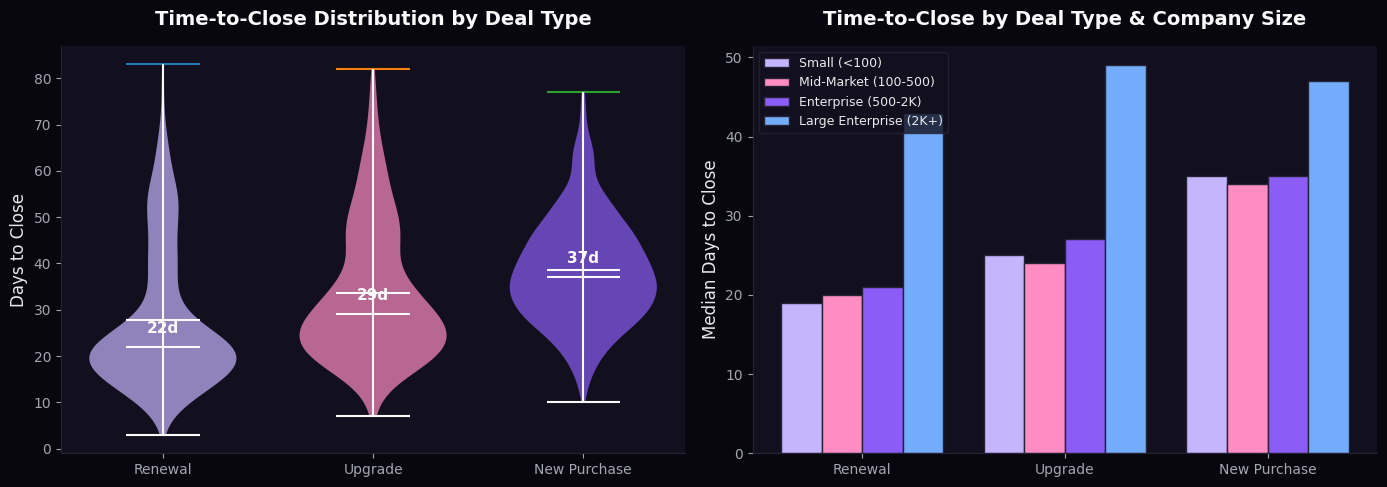

In [10]:
# Time-to-close visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Distribution by deal type (box plot style using violin)
deal_types = ['renewal', 'upgrade', 'new_purchase']
type_labels = ['Renewal', 'Upgrade', 'New Purchase']
type_colors = [CATEGORICAL_PALETTE[i] for i in range(3)]

positions = range(len(deal_types))
for i, dtype in enumerate(deal_types):
    data = df_ttc[df_ttc['deal_type'] == dtype]['days_to_close']
    vp = axes[0].violinplot([data], positions=[i], showmeans=True, showmedians=True, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor(type_colors[i])
        pc.set_alpha(0.7)
    for partname in ['cbars', 'cmins', 'cmaxs', 'cmeans', 'cmedians']:
        if partname in vp:
            vp[partname].set_edgecolor('#FAFAFA')
            vp[partname].set_linewidth(1.5)

axes[0].set_xticks(positions)
axes[0].set_xticklabels(type_labels)
axes[0].set_ylabel('Days to Close')
axes[0].set_title('Time-to-Close Distribution by Deal Type', fontweight='bold', pad=15)

# Add median labels
for i, dtype in enumerate(deal_types):
    median_val = df_ttc[df_ttc['deal_type'] == dtype]['days_to_close'].median()
    axes[0].text(i, median_val + 3, f'{median_val:.0f}d', ha='center', fontsize=11, 
                fontweight='bold', color='#FAFAFA')

# Panel 2: Median time by deal type and size
ttc_pivot = df_ttc.pivot_table(values='days_to_close', index='deal_type', 
                                columns='size_tier', aggfunc='median')
ttc_pivot = ttc_pivot.reindex(columns=['Small (<100)', 'Mid-Market (100-500)', 
                                        'Enterprise (500-2K)', 'Large Enterprise (2K+)'])
ttc_pivot = ttc_pivot.reindex(['renewal', 'upgrade', 'new_purchase'])

x = np.arange(len(ttc_pivot.index))
width = 0.2
for i, col in enumerate(ttc_pivot.columns):
    bars = axes[1].bar(x + i*width, ttc_pivot[col], width, label=col, 
                       color=CATEGORICAL_PALETTE[i], edgecolor='#272336')

axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(['Renewal', 'Upgrade', 'New Purchase'])
axes[1].set_ylabel('Median Days to Close')
axes[1].set_title('Time-to-Close by Deal Type & Company Size', fontweight='bold', pad=15)
axes[1].legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()